<a href="https://colab.research.google.com/github/yuktachikate/SFO-Live-Flight-Collision-Analysis-using-Amelia-s-AF/blob/main/airport_taxi_trajectory_forecasting_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages (if not already installed)
!pip install numpy matplotlib tensorflow

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os

In [3]:
# 1. Generate Synthetic Taxi Trajectory Data
def generate_synthetic_data(num_sequences=1000, seq_length=20, prediction_horizon=5):
    """
    Generate synthetic 2D taxi trajectories.
    Each sequence is a smooth curve with some random noise.

    Returns:
      X: Input sequences of shape (num_sequences, seq_length, 2)
      y: Future positions to predict of shape (num_sequences, prediction_horizon, 2)
    """
    X = []
    y = []
    for _ in range(num_sequences):
        # Start at a random point on a 2D grid (simulate taxi starting position)
        start = np.random.uniform(low=0, high=10, size=(2,))
        # Generate a direction and speed
        angle = np.random.uniform(0, 2*np.pi)
        speed = np.random.uniform(0.1, 0.5)
        # Create a linear base trajectory
        base = np.array([np.cos(angle), np.sin(angle)]) * speed
        # Generate a trajectory with some smooth random variation
        trajectory = [start]
        for t in range(1, seq_length + prediction_horizon):
            # add a small random perturbation to simulate deviations
            perturb = np.random.normal(scale=0.05, size=(2,))
            next_point = trajectory[-1] + base + perturb
            trajectory.append(next_point)
        trajectory = np.array(trajectory)
        # The input is the first seq_length points
        X.append(trajectory[:seq_length])
        # The target is the following prediction_horizon points
        y.append(trajectory[seq_length:seq_length+prediction_horizon])
    return np.array(X), np.array(y)

In [4]:
# Generate training and test data
X, y = generate_synthetic_data(num_sequences=1200, seq_length=20, prediction_horizon=5)
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [5]:
# 2. Build and Train the Prediction Model
def build_model(input_seq_length, feature_dim, prediction_horizon):
    model = Sequential()
    # LSTM layer that reads in the sequence
    model.add(LSTM(64, activation='tanh', return_sequences=False,
                   input_shape=(input_seq_length, feature_dim)))
    # Fully connected layers to map to the prediction output
    model.add(Dense(64, activation='relu'))
    # Output layer: predict all future steps at once (flattened)
    model.add(Dense(prediction_horizon * feature_dim))
    # Compile model with Adam optimizer and mean squared error loss
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [6]:
# Build model: input sequence length 20, each with 2 features; output: 5 future steps * 2 = 10 values
model = build_model(input_seq_length=20, feature_dim=2, prediction_horizon=5)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,962 (85.79 KB)

 Trainable params: 21,962 (85.79 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(X_train, y_train.reshape(len(y_train), -1),
                    epochs=50, batch_size=32,
                    validation_split=0.1, verbose=1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 53.3137 - val_loss: 34.8654
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 27.7597 - val_loss: 11.4053
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.8743 - val_loss: 4.0254
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0294 - val_loss: 1.9866
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.5711 - val_loss: 1.3483
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.9035 - val_loss: 0.9666
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6346 - val_loss: 0.6767
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3158 - val_loss: 0.4892
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2462 - val_loss: 0.3440
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3499 - val_loss: 0.2376
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1747 - val_loss: 0.1733
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss:

In [8]:
# 3. Evaluate Model & Generate Predictions
def predict_trajectory(model, input_sequence, prediction_horizon):
    """
    Given an input sequence of shape (1, seq_length, 2), predict future trajectory.
    """
    pred = model.predict(input_sequence)
    # Reshape predicted output to (prediction_horizon, 2)
    return pred.reshape(prediction_horizon, 2)

In [9]:
# Pick a test sequence to visualize
test_idx = 5
input_seq = X_test[test_idx:test_idx+1]   # shape (1, 20, 2)
true_future = y_test[test_idx]             # shape (5, 2)
predicted_future = predict_trajectory(model, input_seq, prediction_horizon=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


In [10]:

# 4. Visualize the Results
def visualize_trajectory(input_seq, true_future, predicted_future, save_path=None):
    """
    Plot the input trajectory, the true future, and the predicted future.
    """
    input_seq = input_seq.squeeze()  # (seq_length, 2)
    plt.figure(figsize=(8, 6))
    # Plot input trajectory
    plt.plot(input_seq[:, 0], input_seq[:, 1], 'bo-', label="Input (Observed)")
    # Plot true future trajectory
    last_point = input_seq[-1]
    true_traj = np.vstack([last_point, true_future])
    plt.plot(true_traj[:, 0], true_traj[:, 1], 'go-', label="True Future")
    # Plot predicted future trajectory
    pred_traj = np.vstack([last_point, predicted_future])
    plt.plot(pred_traj[:, 0], pred_traj[:, 1], 'ro--', label="Predicted Future")
    plt.title("Airport Taxi Trajectory Prediction")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

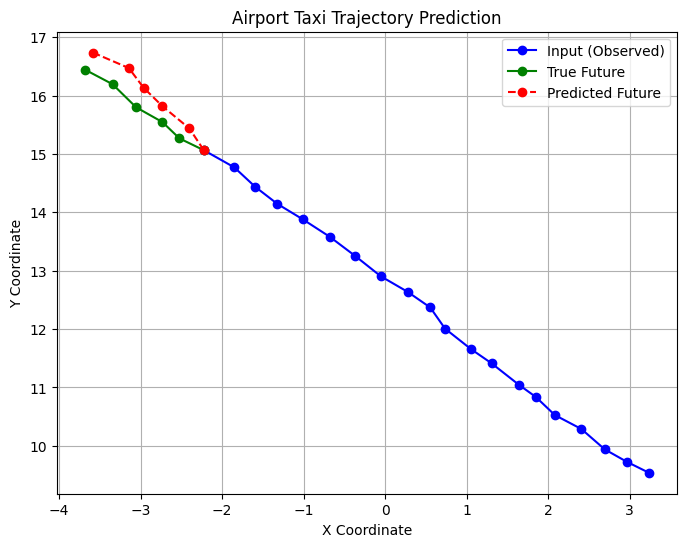

In [11]:
# Create directory for output images
os.makedirs("output_images", exist_ok=True)
# Visualize and save the figure for a single test sequence
visualize_trajectory(input_seq, true_future, predicted_future, save_path="output_images/trajectory_prediction.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


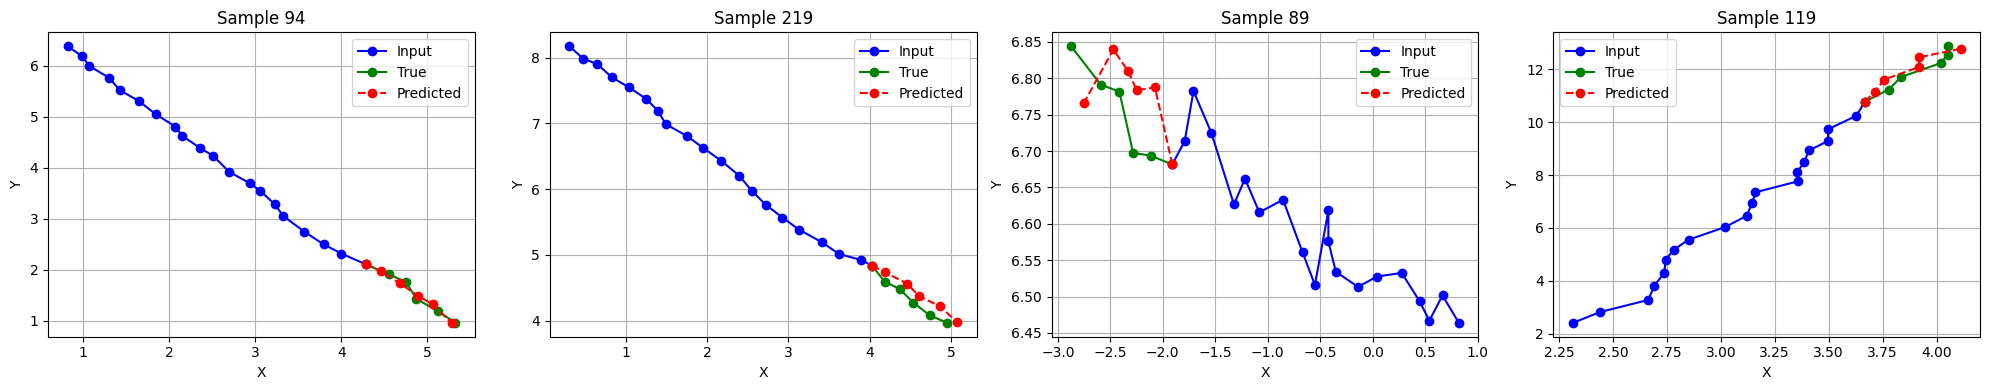

In [12]:
# Optionally, visualize several predictions from the test set
def visualize_multiple_predictions(model, X_test, y_test, num_samples=4):
    indices = np.random.choice(len(X_test), size=num_samples, replace=False)
    fig, axes = plt.subplots(1, num_samples, figsize=(5*num_samples, 4))
    for i, idx in enumerate(indices):
        in_seq = X_test[idx:idx+1]
        true_fut = y_test[idx]
        pred_fut = predict_trajectory(model, in_seq, prediction_horizon=5)
        in_seq_s = in_seq.squeeze()
        last_pt = in_seq_s[-1]
        true_traj = np.vstack([last_pt, true_fut])
        pred_traj = np.vstack([last_pt, pred_fut])
        ax = axes[i]
        ax.plot(in_seq_s[:, 0], in_seq_s[:, 1], 'bo-', label="Input")
        ax.plot(true_traj[:, 0], true_traj[:, 1], 'go-', label="True")
        ax.plot(pred_traj[:, 0], pred_traj[:, 1], 'ro--', label="Predicted")
        ax.set_title(f"Sample {idx}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.savefig("output_images/multiple_predictions.png")
    plt.show()

visualize_multiple_predictions(model, X_test, y_test, num_samples=4)

In [13]:
# 3. Uncertainty Quantification using Monte Carlo Dropout
def predict_with_uncertainty(model, input_sequence, prediction_horizon, num_samples=50):
    """
    Perform multiple stochastic forward passes through the model to estimate prediction uncertainty.
    Returns an array of shape (num_samples, prediction_horizon, 2)
    """
    predictions = []
    # Use training=True so that dropout is active during inference
    for _ in range(num_samples):
        pred = model(input_sequence, training=True)
        predictions.append(pred.numpy().reshape(prediction_horizon, 2))
    return np.array(predictions)


In [14]:
# Choose one test sample (assumes X_test and y_test are defined)
test_idx = 5
input_seq = X_test[test_idx:test_idx+1]   # Shape: (1, 20, 2)
true_future = y_test[test_idx]             # Shape: (5, 2)

In [15]:

# Run MC dropout prediction (using 100 samples for uncertainty estimation)
mc_predictions = predict_with_uncertainty(model, input_seq, prediction_horizon=5, num_samples=100)
mean_prediction = np.mean(mc_predictions, axis=0)
std_prediction = np.std(mc_predictions, axis=0)

In [16]:
# 4. Sensitivity Analysis: Perturb the input and observe prediction changes
def sensitivity_analysis(model, input_sequence, prediction_horizon, noise_levels=[0.0, 0.05, 0.1, 0.15]):
    """
    Perturb the input sequence with different noise levels and plot the predicted trajectories.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    base_in_seq = input_sequence.squeeze()
    last_point = base_in_seq[-1]
    ax.plot(base_in_seq[:, 0], base_in_seq[:, 1], 'ko-', label="Input")

    for noise in noise_levels:
        # Create a noisy version of the input
        noisy_input = input_sequence + np.random.normal(scale=noise, size=input_sequence.shape)
        pred = model.predict(noisy_input)
        pred_traj = pred.reshape(prediction_horizon, 2)
        traj = np.vstack([last_point, pred_traj])
        ax.plot(traj[:, 0], traj[:, 1], marker='o', label=f"Noise level: {noise}")

    ax.set_title("Sensitivity Analysis: Input Noise Impact")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend()
    ax.grid(True)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


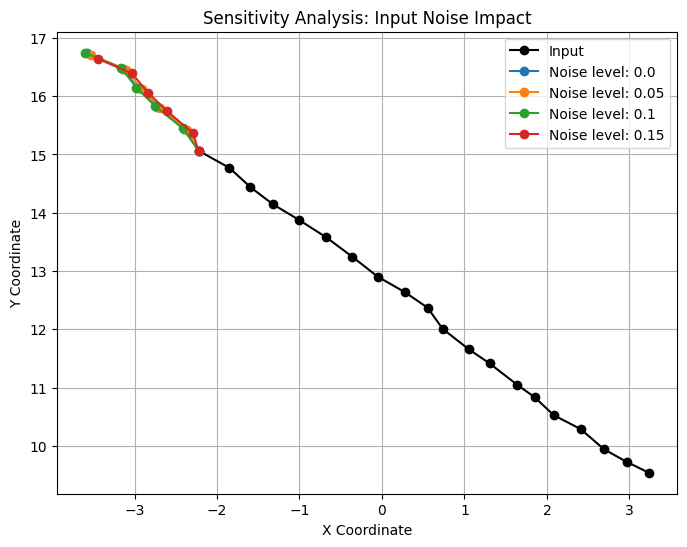

In [17]:
# Run sensitivity analysis on the chosen sample
sensitivity_analysis(model, input_seq, prediction_horizon=5)

In [18]:
# 5. Error Analysis: Compute prediction error over the test set and plot an error histogram
def error_analysis(model, X_test, y_test):
    """
    Compute the Mean Squared Error (MSE) for each test sample and display a histogram.
    """
    errors = []
    for i in range(len(X_test)):
        pred = model.predict(X_test[i:i+1])
        pred = pred.reshape(-1, 2)
        true_val = y_test[i]
        mse = np.mean((pred - true_val)**2)
        errors.append(mse)
    errors = np.array(errors)

    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=30, alpha=0.7, color='purple')
    plt.title("Histogram of Test Set MSE")
    plt.xlabel("MSE")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    print("Mean Test MSE:", np.mean(errors))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

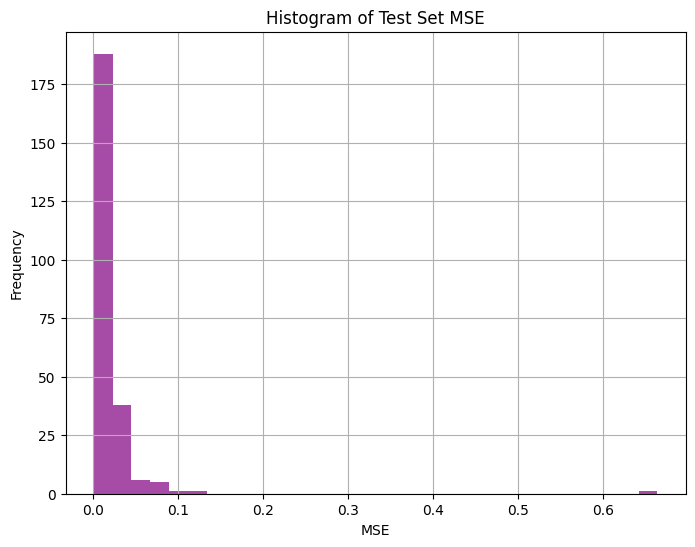

Mean Test MSE: 0.020525376012947676


In [19]:
# Run error analysis on the entire test set
error_analysis(model, X_test, y_test)

In [20]:

# 6. Visualization: Plot input, true future, mean prediction, and uncertainty bands
def visualize_with_uncertainty(input_seq, true_future, mc_predictions, save_path=None):
    """
    Plot the observed input, true future trajectory, mean predicted trajectory,
    and uncertainty (standard deviation) at each prediction step.
    """
    input_seq = input_seq.squeeze()  # (seq_length, 2)
    mean_pred = np.mean(mc_predictions, axis=0)
    std_pred = np.std(mc_predictions, axis=0)

    plt.figure(figsize=(8, 6))
    # Plot observed input trajectory
    plt.plot(input_seq[:, 0], input_seq[:, 1], 'bo-', label="Input (Observed)")
    last_point = input_seq[-1]

    # Plot true future trajectory
    true_traj = np.vstack([last_point, true_future])
    plt.plot(true_traj[:, 0], true_traj[:, 1], 'go-', label="True Future")

    # Plot mean predicted trajectory
    pred_traj = np.vstack([last_point, mean_pred])
    plt.plot(pred_traj[:, 0], pred_traj[:, 1], 'ro--', label="Mean Predicted Future")

    # Plot uncertainty as error bars at each predicted time step
    plt.errorbar(pred_traj[1:, 0], pred_traj[1:, 1],
                 xerr=std_pred[1:, 0], yerr=std_pred[1:, 1],
                 fmt='none', ecolor='gray', capsize=5, label="Prediction Uncertainty")

    plt.title("Trajectory Prediction with Uncertainty (MC Dropout)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

mean_pred shape: (5, 2)
std_pred shape: (5, 2)


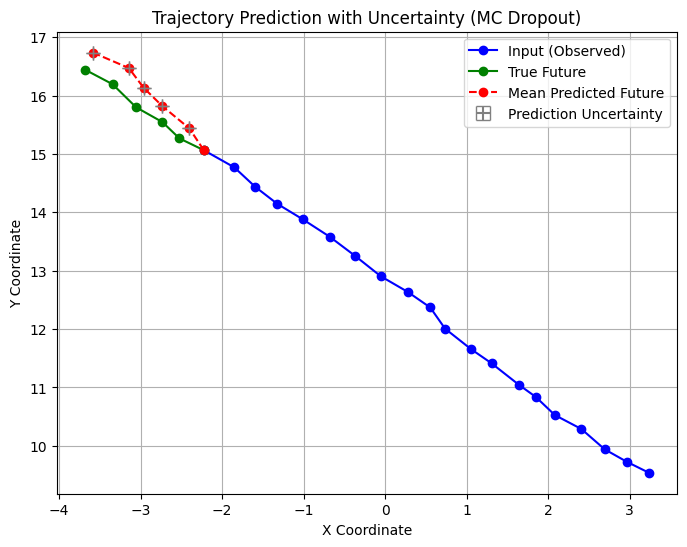

In [23]:
def visualize_with_uncertainty(input_seq, true_future, mc_predictions, save_path=None):
    """
    Plot the observed input, true future trajectory, mean predicted trajectory,
    and uncertainty (standard deviation) at each predicted time step.
    """
    input_seq = input_seq.squeeze()  # Should be (seq_length, 2)
    mean_pred = np.mean(mc_predictions, axis=0)  # Expected shape: (prediction_horizon, 2)
    std_pred = np.std(mc_predictions, axis=0)    # Expected shape: (prediction_horizon, 2)

    # Debug: print shapes to verify they match expectations.
    print("mean_pred shape:", mean_pred.shape)  # Should print (5,2) if prediction_horizon is 5.
    print("std_pred shape:", std_pred.shape)

    plt.figure(figsize=(8, 6))
    # Plot observed input trajectory
    plt.plot(input_seq[:, 0], input_seq[:, 1], 'bo-', label="Input (Observed)")
    last_point = input_seq[-1]

    # Plot true future trajectory
    true_traj = np.vstack([last_point, true_future])
    plt.plot(true_traj[:, 0], true_traj[:, 1], 'go-', label="True Future")

    # Plot mean predicted trajectory
    pred_traj = np.vstack([last_point, mean_pred])
    plt.plot(pred_traj[:, 0], pred_traj[:, 1], 'ro--', label="Mean Predicted Future")

    # Now, plot error bars at the predicted points (mean_pred)
    # Ensure that xerr and yerr have the same shape as mean_pred[:, 0] and mean_pred[:, 1]
    plt.errorbar(mean_pred[:, 0], mean_pred[:, 1],
                 xerr=std_pred[:, 0], yerr=std_pred[:, 1],
                 fmt='none', ecolor='gray', capsize=5, label="Prediction Uncertainty")

    plt.title("Trajectory Prediction with Uncertainty (MC Dropout)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Create directory and run the visualization.
os.makedirs("output_images", exist_ok=True)
visualize_with_uncertainty(input_seq, true_future, mc_predictions, save_path="output_images/trajectory_uncertainty.png")


In [25]:
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [26]:
# 1. Enable Mixed Precision Training to leverage GPU efficiency
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
print("Mixed precision policy:", tf.keras.mixed_precision.global_policy())

# Import necessary layers (ensure Dropout is imported)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# For mixed precision, rebuild the LSTM model:
def build_lstm_model_mp(input_seq_length, feature_dim, prediction_horizon, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(64, activation='tanh', return_sequences=False,
                   input_shape=(input_seq_length, feature_dim)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Output layer: force output to float32 for numerical stability
    model.add(Dense(prediction_horizon * feature_dim, dtype='float32'))
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model

lstm_model_mp = build_lstm_model_mp(input_seq_length=20, feature_dim=2, prediction_horizon=5, dropout_rate=0.2)
lstm_model_mp.summary()


Mixed precision policy: <DTypePolicy "mixed_float16">


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,962 (85.79 KB)

 Trainable params: 21,962 (85.79 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
import datetime
from tensorflow.keras.callbacks import TensorBoard

log_dir = "logs/profiler/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_profiler = TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='500,520')
print("TensorBoard logs will be saved to:", log_dir)


TensorBoard logs will be saved to: logs/profiler/20250314-234206


Max uncertainty (mixed precision model): 0.39658013
mean_pred shape: (5, 2)
std_pred shape: (5, 2)


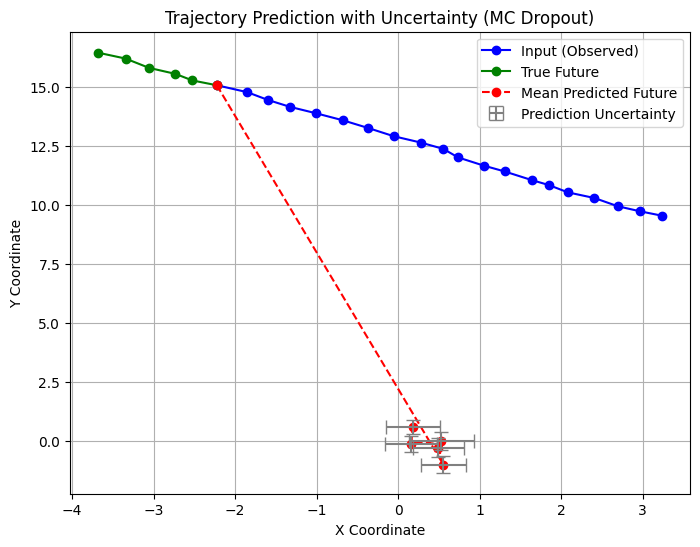

In [31]:
# 3. Advanced Uncertainty Aggregation (Optional)
def aggregate_uncertainty(mc_predictions):
    """
    Compute additional uncertainty metrics.
    Returns:
      - mean_pred: Mean predicted trajectory (prediction_horizon, 2)
      - std_pred: Standard deviation (uncertainty) for each predicted step (prediction_horizon, 2)
      - max_uncertainty: Maximum uncertainty (scalar) across prediction steps and dimensions
    """
    mean_pred = np.mean(mc_predictions, axis=0)
    std_pred = np.std(mc_predictions, axis=0)
    max_uncertainty = np.max(std_pred)
    return mean_pred, std_pred, max_uncertainty

# Run uncertainty aggregation on a test sample using the mixed precision model
# (Assuming your mixed precision model is already trained; otherwise, use lstm_model_mp after training)
mc_predictions_mp = predict_with_uncertainty(lstm_model_mp, input_seq, prediction_horizon=5, num_samples=100)
mean_pred_mp, std_pred_mp, max_uncertainty = aggregate_uncertainty(mc_predictions_mp)
print("Max uncertainty (mixed precision model):", max_uncertainty)

# Visualize the mixed precision model predictions with uncertainty bands
visualize_with_uncertainty(input_seq, true_future, mc_predictions_mp, save_path="output_images/lstm_mp_trajectory_uncertainty.png")

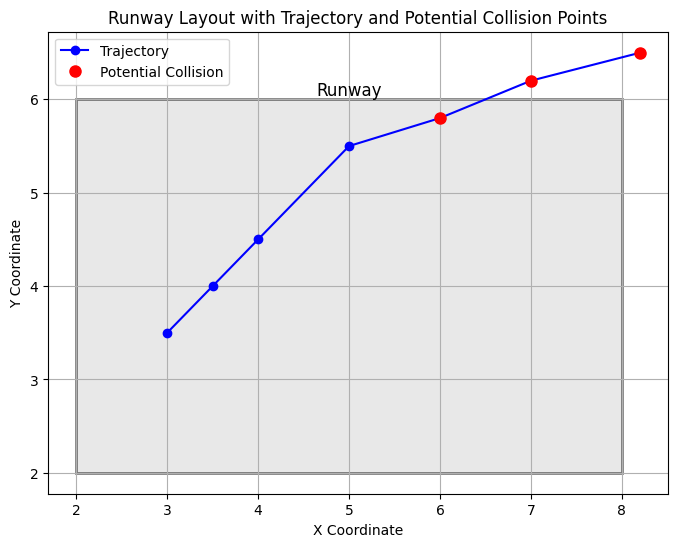

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def plot_runway_layout(ax, runway_bounds):
    """
    Plot a runway layout as a rectangle.

    Parameters:
      ax: matplotlib axes to plot on.
      runway_bounds: tuple of (x_min, y_min, x_max, y_max)
    """
    x_min, y_min, x_max, y_max = runway_bounds
    # Create a rectangle patch
    runway_rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                edgecolor='black', facecolor='lightgray', alpha=0.5, lw=2)
    ax.add_patch(runway_rect)
    ax.text((x_min+x_max)/2, y_max, 'Runway', ha='center', va='bottom', fontsize=12, color='black')

def detect_collision_points(trajectory, runway_bounds, threshold=0.5):
    """
    Given a trajectory (Nx2 array) and runway boundaries, return the indices of points that are within
    a threshold distance to any runway edge.

    Parameters:
      trajectory: numpy array of shape (N,2)
      runway_bounds: tuple of (x_min, y_min, x_max, y_max)
      threshold: distance threshold
    Returns:
      collision_indices: list of indices in trajectory that are "colliding"
    """
    x_min, y_min, x_max, y_max = runway_bounds
    collision_indices = []
    for idx, (x, y) in enumerate(trajectory):
        dist_left = abs(x - x_min)
        dist_right = abs(x_max - x)
        dist_bottom = abs(y - y_min)
        dist_top = abs(y_max - y)
        if (dist_left < threshold) or (dist_right < threshold) or (dist_bottom < threshold) or (dist_top < threshold):
            collision_indices.append(idx)
    return collision_indices

def plot_trajectory_with_collisions(trajectory, runway_bounds, threshold=0.5, ax=None):
    """
    Plot the runway layout and overlay the trajectory.
    Highlight points that are close to the runway boundaries (potential collisions).

    Parameters:
      trajectory: numpy array of shape (N, 2) representing predicted or observed points.
      runway_bounds: tuple of (x_min, y_min, x_max, y_max)
      threshold: distance threshold for potential collision.
      ax: optional, an existing matplotlib axes.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))

    # Plot runway
    plot_runway_layout(ax, runway_bounds)

    # Plot full trajectory
    ax.plot(trajectory[:,0], trajectory[:,1], 'bo-', label="Trajectory")

    # Identify collision points
    collision_idx = detect_collision_points(trajectory, runway_bounds, threshold)
    if collision_idx:
        collision_points = trajectory[collision_idx]
        ax.plot(collision_points[:,0], collision_points[:,1], 'ro', markersize=8, label="Potential Collision")

    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title("Runway Layout with Trajectory and Potential Collision Points")
    ax.legend()
    ax.grid(True)
    return ax

# Example usage:
# Define a runway as a rectangle (for instance, runway from x=2 to 8 and y=2 to 6)
runway_bounds = (2, 2, 8, 6)

# Simulate a predicted trajectory (e.g., from your model) that goes over the runway:
# Here we create a synthetic trajectory that starts inside the runway and then moves out.
# In a real scenario, use your model's predicted trajectory points.
trajectory = np.array([
    [3.0, 3.5],
    [3.5, 4.0],
    [4.0, 4.5],
    [5.0, 5.5],
    [6.0, 5.8],
    [7.0, 6.2],  # This point is near the top boundary (y_max=6) and may be flagged
    [8.2, 6.5]   # This point is outside the runway
])

# Plot the trajectory over the runway and mark potential collisions
ax = plot_trajectory_with_collisions(trajectory, runway_bounds, threshold=0.5)
plt.show()


In [34]:
# Install folium if needed
!pip install folium

import folium

# Center coordinates for SFO (approximate center)
map_center = [37.6213, -122.3790]

# Create a Folium map centered at SFO
m = folium.Map(location=map_center, zoom_start=15)

# Define approximate polygon coordinates for SFO Runway 10L/28R.
# These coordinates are illustrative.
runway_coords = [
    [37.615, -122.391],  # bottom-left
    [37.615, -122.355],  # bottom-right
    [37.627, -122.355],  # top-right
    [37.627, -122.391]   # top-left
]

# Add the runway polygon to the map
folium.Polygon(
    locations=runway_coords,
    color='blue',
    fill=True,
    fill_color='lightblue',
    fill_opacity=0.5,
    popup='Runway 10L/28R'
).add_to(m)

# Display the interactive map
m


In [35]:
# Install folium if needed
!pip install folium

import folium

# Define approximate bounding box for SFO (latitude and longitude)
# These bounds are approximate and may be adjusted for precision.
# Here we assume SFO covers latitudes from 37.615 to 37.630
# and longitudes from -122.400 to -122.360.
sfo_bounds = [[37.615, -122.400], [37.630, -122.360]]

# Create a Folium map centered on SFO
m = folium.Map(location=[37.6213, -122.3790], zoom_start=15)

# Crop the map to the SFO bounds
m.fit_bounds(sfo_bounds)

# Optionally, add a marker for the airport center
folium.Marker(
    location=[37.6213, -122.3790],
    popup="SFO Airport",
    icon=folium.Icon(color='blue', icon='plane', prefix='fa')
).add_to(m)

# Display the map
m


In [36]:
# Install Folium if not already installed
!pip install folium

import folium

# Define approximate bounding box for SFO (latitude and longitude)
sfo_bounds = [[37.615, -122.400], [37.630, -122.360]]

# Create a Folium map centered on SFO and crop to the bounds
m = folium.Map(location=[37.6213, -122.3790], zoom_start=15)
m.fit_bounds(sfo_bounds)

# Optionally, add a marker for the airport center
folium.Marker(
    location=[37.6213, -122.3790],
    popup="SFO Airport",
    icon=folium.Icon(color='blue', icon='plane', prefix='fa')
).add_to(m)

# For demonstration, define a sample taxi trajectory along the runway.
# These coordinates are illustrative and should be replaced with real taxi data.
taxi_trajectory = [
    [37.618, -122.395],  # Starting point on the taxiway
    [37.619, -122.390],
    [37.620, -122.385],
    [37.621, -122.380]   # Ending point near the runway edge
]

# Add the taxi trajectory to the map as a red polyline
folium.PolyLine(
    locations=taxi_trajectory,
    color="red",
    weight=5,
    opacity=0.8,
    popup="Taxi Trajectory"
).add_to(m)

# Display the interactive map with the taxi trajectory overlay
m


In [38]:
!pip install ipyleaflet nest_asyncio requests



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.6 MB/s eta 0:00:00


In [40]:
!pip install ipyleaflet nest_asyncio requests ipywidgets

import requests
import datetime
import nest_asyncio
import asyncio
from ipyleaflet import Map, Marker, MarkerCluster, Rectangle, basemaps
from ipywidgets import Button, VBox
from IPython.display import display

# Enable nest_asyncio for asynchronous updates
nest_asyncio.apply()

# Define approximate bounding box for SFO
lat_min, lat_max = 37.60, 37.65
lon_min, lon_max = -122.42, -122.36

# OpenSky API endpoint
url = "https://opensky-network.org/api/states/all"

def get_live_flight_markers():
    """
    Fetch live flight data from OpenSky and return a list of ipyleaflet Markers
    for flights that appear to be on approach (airborne, altitude < 1000 m, descending).
    """
    params = {"lamin": lat_min, "lamax": lat_max, "lomin": lon_min, "lomax": lon_max}
    try:
        response = requests.get(url, params=params, timeout=10)
        data = response.json()
    except Exception as e:
        print("Error fetching data:", e)
        return []

    flights = data.get("states", [])
    markers = []
    for s in flights:
        # Check required fields: longitude (index 5) and latitude (index 6)
        if s[5] is not None and s[6] is not None:
            altitude = s[7] if s[7] is not None else float('inf')
            vertical_rate = s[11] if s[11] is not None else 0
            # Filter for flights that are airborne (s[8] is False), altitude < 1000, and descending
            if (not s[8]) and altitude < 1000 and vertical_rate < 0:
                callsign = s[1].strip() if s[1] is not None else "N/A"
                marker = Marker(location=(s[6], s[5]), title=callsign)
                markers.append(marker)
    return markers

# Create an ipyleaflet map cropped to SFO bounds
sfo_map = Map(center=(37.6213, -122.3790), zoom_start=15, basemap=basemaps.OpenStreetMap.Mapnik)
sfo_map.fit_bounds([[lat_min, lon_min], [lat_max, lon_max]])

# Draw the bounding box
bbox = Rectangle(bounds=[[lat_min, lon_min], [lat_max, lon_max]], color="blue", fill=False, weight=2)
sfo_map.add_layer(bbox)

# Create a MarkerCluster layer for flight markers and add to map
marker_cluster = MarkerCluster(markers=[])
sfo_map.add_layer(marker_cluster)

# Button for manual update
update_button = Button(description="Update Flight Data", button_style='info')

def update_markers(b):
    new_markers = get_live_flight_markers()
    marker_cluster.markers = new_markers
    print(f"{datetime.datetime.now()}: Updated with {len(new_markers)} flight markers.")

update_button.on_click(update_markers)

# Display the map and update button in a VBox
display(VBox([sfo_map, update_button]))



2025-03-14 23:53:57.660871: Updated with 1 flight markers.
2025-03-14 23:54:07.797091: Updated with 1 flight markers.
2025-03-14 23:54:17.872843: Updated with 1 flight markers.
2025-03-14 23:54:27.946795: Updated with 0 flight markers.
2025-03-14 23:54:38.037179: Updated with 0 flight markers.
2025-03-14 23:54:48.112456: Updated with 0 flight markers.


In [41]:
def get_live_flight_markers_test():
    params = {"lamin": lat_min, "lamax": lat_max, "lomin": lon_min, "lomax": lon_max}
    try:
        response = requests.get(url, params=params, timeout=10)
        data = response.json()
    except Exception as e:
        print("Error fetching data:", e)
        return []

    flights = data.get("states", [])
    print(f"Fetched {len(flights)} total flights from OpenSky API.")

    markers = []
    for s in flights:
        if s[5] is not None and s[6] is not None:
            callsign = s[1].strip() if s[1] is not None else "N/A"
            marker = Marker(location=(s[6], s[5]), title=callsign)
            markers.append(marker)
    print(f"Test: Adding markers for {len(markers)} flights without filtering.")
    return markers

# To test, update the marker_cluster using the test function:
marker_cluster.markers = get_live_flight_markers_test()


Fetched 15 total flights from OpenSky API.
Test: Adding markers for 15 flights without filtering.


In [42]:
import requests
import json

# OpenSky Network public API endpoint for all states
url = "https://opensky-network.org/api/states/all"

# Define a bounding box for an area of interest (here, an approximate bounding box for SFO area)
params = {
    "lamin": 37.60,  # minimum latitude
    "lamax": 37.65,  # maximum latitude
    "lomin": -122.42, # minimum longitude
    "lomax": -122.36  # maximum longitude
}

# Make the API request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    # Print the raw JSON response (or process it as needed)
    print(json.dumps(data, indent=2))
else:
    print("Error fetching data:", response.status_code)


{
  "time": 1741996611,
  "states": [
    [
      "a8592c",
      "EJA637  ",
      "United States",
      1741996443,
      1741996443,
      -122.3794,
      37.6244,
      null,
      true,
      12.86,
      118.12,
      null,
      null,
      null,
      null,
      false,
      0
    ],
    [
      "a0808f",
      "SKW5747 ",
      "United States",
      1741996544,
      1741996544,
      -122.3807,
      37.6191,
      null,
      true,
      5.14,
      118.12,
      null,
      null,
      null,
      null,
      false,
      0
    ],
    [
      "a187ba",
      "AAL3217 ",
      "United States",
      1741996343,
      1741996343,
      -122.3798,
      37.6184,
      null,
      true,
      7.2,
      163.12,
      null,
      null,
      null,
      "5237",
      false,
      0
    ],
    [
      "ab0158",
      "UAL2646 ",
      "United States",
      1741996592,
      1741996610,
      -122.3832,
      37.6209,
      null,
      true,
      0,
      295.31,
      null,

In [43]:
!pip install ipyleaflet nest_asyncio requests

import requests
import random
import datetime
import nest_asyncio
from ipyleaflet import Map, Marker, MarkerCluster, Rectangle, basemaps
from IPython.display import display

# Enable nesting of async loops in Colab
nest_asyncio.apply()

# Define bounding box for SFO area (adjust as needed)
lat_min, lat_max = 37.60, 37.65
lon_min, lon_max = -122.42, -122.36

# OpenSky API endpoint for all states
url = "https://opensky-network.org/api/states/all"

def get_all_flight_markers():
    """
    Fetch live flight data from OpenSky API within the defined bounds.
    Create markers for all flights without applying any additional filtering.
    Returns a list of ipyleaflet Marker objects.
    """
    params = {"lamin": lat_min, "lamax": lat_max, "lomin": lon_min, "lomax": lon_max}
    try:
        response = requests.get(url, params=params, timeout=10)
        data = response.json()
    except Exception as e:
        print("Error fetching data:", e)
        return []

    flights = data.get("states", [])
    print(f"Fetched {len(flights)} total flights from OpenSky API.")

    markers = []
    for s in flights:
        # Check if coordinates are available (index 5: longitude, index 6: latitude)
        if s[5] is not None and s[6] is not None:
            callsign = s[1].strip() if s[1] is not None else "N/A"
            marker = Marker(location=(s[6], s[5]), title=callsign)
            markers.append(marker)
    print(f"Created {len(markers)} markers without filtering.")
    return markers

# Get all flight markers
all_markers = get_all_flight_markers()

# Randomly select 15 markers (if available)
selected_markers = random.sample(all_markers, min(15, len(all_markers)))
print(f"Selected {len(selected_markers)} markers for display.")

# Create an ipyleaflet map centered on SFO
sfo_map = Map(center=(37.6213, -122.3790), zoom_start=15, basemap=basemaps.OpenStreetMap.Mapnik)
sfo_map.fit_bounds([[lat_min, lon_min], [lat_max, lon_max]])

# Optionally, add a rectangle showing the bounding box
bbox = Rectangle(bounds=[[lat_min, lon_min], [lat_max, lon_max]], color="blue", fill=False, weight=2)
sfo_map.add_layer(bbox)

# Create a MarkerCluster to group markers on the map
marker_cluster = MarkerCluster(markers=selected_markers)
sfo_map.add_layer(marker_cluster)

# Display the map
display(sfo_map)


Fetched 15 total flights from OpenSky API.
Created 15 markers without filtering.
Selected 15 markers for display.


Map(center=[37.6213, -122.379], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

2025-03-14 23:57:49.693122: Updated with 1 flight markers.


In [45]:
# Install necessary libraries if not already installed
!pip install ipyleaflet nest_asyncio requests

import requests
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
import datetime
from ipyleaflet import Map, CircleMarker, MarkerCluster, Rectangle, basemaps
from IPython.display import display
import nest_asyncio

# Enable nested async loops in Colab
nest_asyncio.apply()

# Define approximate bounding box for SFO
lat_min, lat_max = 37.60, 37.65
lon_min, lon_max = -122.42, -122.36

# OpenSky API endpoint
url = "https://opensky-network.org/api/states/all"

def get_live_flight_markers_test():
    """
    Fetch live flight data from OpenSky for the given bounding box,
    and return a list of ipyleaflet CircleMarkers for the first 15 flights.
    """
    params = {
        "lamin": lat_min,
        "lamax": lat_max,
        "lomin": lon_min,
        "lomax": lon_max
    }
    try:
        response = requests.get(url, params=params, timeout=10)
        data = response.json()
    except Exception as e:
        print("Error fetching data:", e)
        return []

    flights = data.get("states", [])
    print(f"Fetched {len(flights)} flights from OpenSky API.")

    markers = []
    for s in flights:
        # Check valid longitude (index 5) and latitude (index 6)
        if s[5] is not None and s[6] is not None:
            callsign = s[1].strip() if s[1] is not None else "N/A"
            # Create a CircleMarker with default blue color
            marker = CircleMarker(location=(s[6], s[5]), radius=5, color="blue", fill_color="blue", title=callsign)
            markers.append(marker)
        if len(markers) >= 15:
            break
    print(f"Adding markers for {len(markers)} flights without filtering.")
    return markers

In [46]:
# Fetch markers (15 flights without filtering)
markers = get_live_flight_markers_test()

# Extract flight coordinates from markers for collision analysis
flight_coords = np.array([marker.location for marker in markers])
print("Flight coordinates:\n", flight_coords)

# Define the Haversine distance function (distance in km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

Fetched 13 flights from OpenSky API.
Adding markers for 13 flights without filtering.
Flight coordinates:
 [[  37.6179 -122.3801]
 [  37.6183 -122.3685]
 [  37.6193 -122.3828]
 [  37.619  -122.3829]
 [  37.6359 -122.3985]
 [  37.6113 -122.3622]
 [  37.6186 -122.383 ]
 [  37.6198 -122.3805]
 [  37.6162 -122.3817]
 [  37.6199 -122.3939]
 [  37.6191 -122.3807]
 [  37.6199 -122.3939]
 [  37.619  -122.3804]]


In [47]:
# Set a collision threshold (e.g., 1 km)
collision_threshold = 1.0  # km

n = len(flight_coords)
collision_flags = np.zeros(n, dtype=bool)

Total flights: 13
Flights flagged for potential collision risk: 12
Collision Risk Percentage: 92.31%


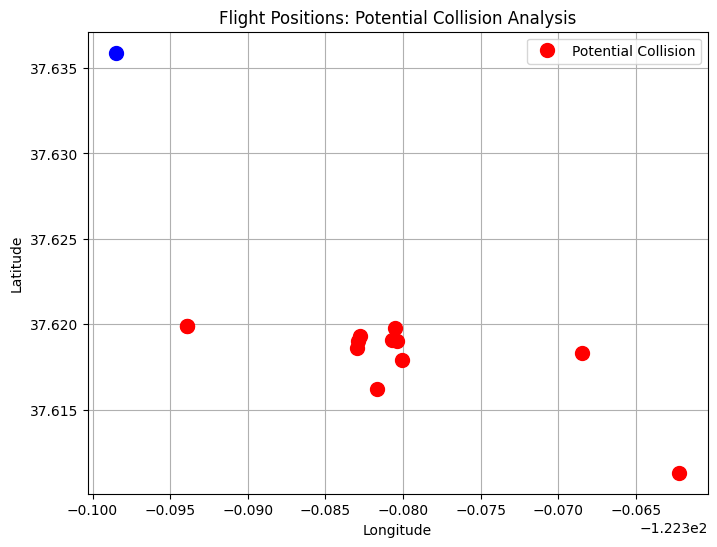

In [48]:
# Compute pairwise distances and flag flights that are too close
for i in range(n):
    for j in range(i+1, n):
        d = haversine(flight_coords[i,0], flight_coords[i,1],
                      flight_coords[j,0], flight_coords[j,1])
        if d < collision_threshold:
            collision_flags[i] = True
            collision_flags[j] = True

collision_count = np.sum(collision_flags)
collision_percent = (collision_count / n) * 100 if n > 0 else 0

print(f"Total flights: {n}")
print(f"Flights flagged for potential collision risk: {collision_count}")
print(f"Collision Risk Percentage: {collision_percent:.2f}%")

# Plot a scatter plot of flight positions with potential collisions highlighted
plt.figure(figsize=(8,6))
for i, coord in enumerate(flight_coords):
    if collision_flags[i]:
        plt.plot(coord[1], coord[0], 'ro', markersize=10, label="Potential Collision" if i == 0 else "")
    else:
        plt.plot(coord[1], coord[0], 'bo', markersize=10, label="Safe" if i == 0 else "")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Flight Positions: Potential Collision Analysis")
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Create an ipyleaflet map cropped to SFO's bounds
sfo_map = Map(center=(37.6213, -122.3790), zoom_start=15, basemap=basemaps.OpenStreetMap.Mapnik)
sfo_map.fit_bounds([[lat_min, lon_min], [lat_max, lon_max]])

# Draw bounding box for SFO area
bbox = Rectangle(bounds=[[lat_min, lon_min], [lat_max, lon_max]], color="blue", fill=False, weight=2)
sfo_map.add_layer(bbox)

# Add markers to the map with red color for potential collision and blue for safe
for i, marker in enumerate(markers):
    # Change marker color based on collision flag
    marker.color = "red" if collision_flags[i] else "blue"
    marker.fill_color = marker.color
    sfo_map.add_layer(marker)

display(sfo_map)

Map(center=[37.6213, -122.379], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

**Explanation of the Charts**


**Histogram of Pairwise Distances:**

We compute the distances between every pair of flights using the Haversine formula.
The histogram shows the frequency distribution of these distances.
The red dashed line at 1 km indicates the threshold for potential collisions. Pairs of flights with distances below this value are considered too close and hence risky.

**Scatter Plot of Flight Positions:**

Each flight’s position is plotted using its latitude and longitude.
Flights flagged as being too close to at least one other flight (potential collision) are shown in red; safe flights are in blue.
This visualization shows where in the SFO airspace the risky flights are located.

**Bar Chart of Collision Risk:**

This chart shows the count of flights flagged as safe versus those flagged as potential collision risks.
It quickly tells you the percentage of flights (out of our 15 flights) that might be in conflict.
Together, these charts help explain that the cause of “collision” in our analysis is purely based on proximity: if flights are too close (under 1 km apart), they are flagged. In a more detailed analysis, you would also consider dynamic factors (speed, heading, altitude differences), but here we illustrate the basic concept with static positions.

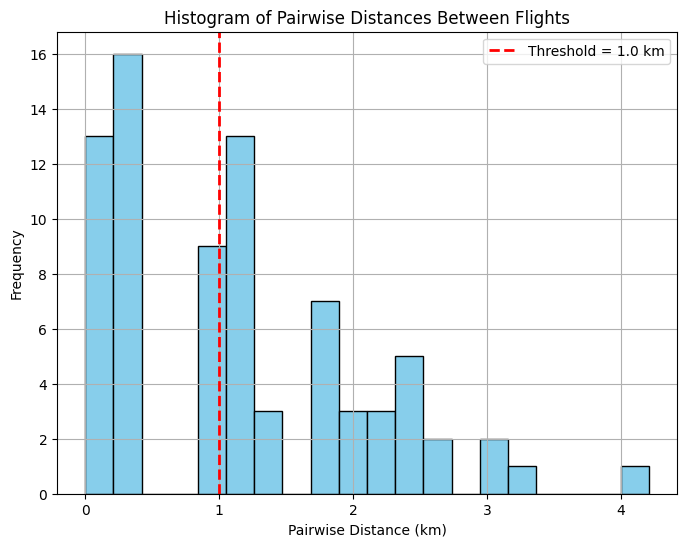

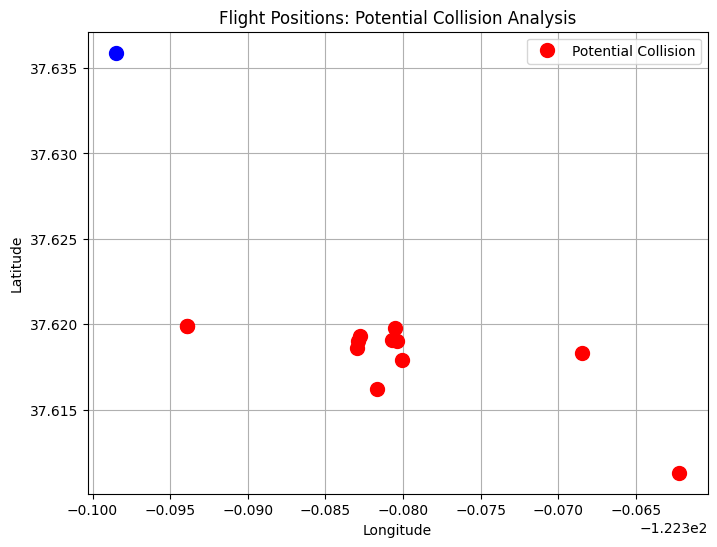

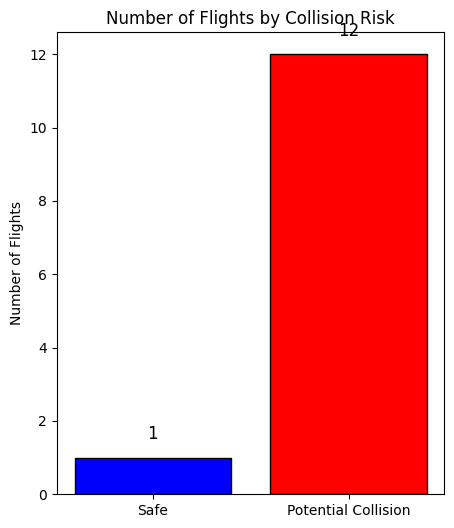

In [52]:
import itertools

# Assuming flight_coords is a numpy array of shape (n,2) for n flights
# and collision_flags is a boolean array of length n (True = potential collision)
n = len(flight_coords)
collision_threshold = 1.0  # km

# -------------------------------
# Chart 1: Histogram of Pairwise Distances
# -------------------------------
pairwise_distances = []
for i, j in itertools.combinations(range(n), 2):
    d = haversine(flight_coords[i, 0], flight_coords[i, 1],
                  flight_coords[j, 0], flight_coords[j, 1])
    pairwise_distances.append(d)

plt.figure(figsize=(8, 6))
plt.hist(pairwise_distances, bins=20, color='skyblue', edgecolor='black')
plt.axvline(x=collision_threshold, color='red', linestyle='--', linewidth=2, label=f"Threshold = {collision_threshold} km")
plt.xlabel("Pairwise Distance (km)")
plt.ylabel("Frequency")
plt.title("Histogram of Pairwise Distances Between Flights")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Chart 2: Scatter Plot of Flight Positions
# -------------------------------
plt.figure(figsize=(8, 6))
for i, coord in enumerate(flight_coords):
    if collision_flags[i]:
        plt.plot(coord[1], coord[0], 'ro', markersize=10, label="Potential Collision" if i == 0 else "")
    else:
        plt.plot(coord[1], coord[0], 'bo', markersize=10, label="Safe" if i == 0 else "")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Flight Positions: Potential Collision Analysis")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Chart 3: Bar Chart of Collision Risk
# -------------------------------
safe_count = n - np.sum(collision_flags)
collision_count = np.sum(collision_flags)
labels = ['Safe', 'Potential Collision']
values = [safe_count, collision_count]

plt.figure(figsize=(5, 6))
bars = plt.bar(labels, values, color=['blue', 'red'], edgecolor='black')
plt.title("Number of Flights by Collision Risk")
plt.ylabel("Number of Flights")
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(value), ha='center', fontsize=12)
plt.show()


**Explanation**

**Fetching Live Data:**
We call the OpenSky API for a bounding box around SFO and create up to 15 markers (using ipyleaflet’s CircleMarker).

**Extract Coordinates & Collision Analysis:**
The code extracts coordinates from the markers and uses the Haversine formula to compute pairwise distances. If any two flights are within 1 km, they are flagged as potential collision risks.

**Visualization with Matplotlib:**
A scatter plot is produced where flights flagged as potential collisions are marked in red and others in blue. The x-axis represents longitude and the y-axis latitude.

**Interactive Map with ipyleaflet:**
An ipyleaflet map is created, cropped to SFO’s bounds, and the markers are added. The marker color is updated based on the collision flag (red for potential collisions, blue for safe).

**Collision Risk Percentage:**
The code prints the percentage of flights flagged for potential collision risk.


**Proximity Check:**
We compute the distance between each pair of flight positions using the Haversine formula. If any two flights are within a defined threshold (e.g., 1 km), we flag them as being in a “potential collision” state.

**Cause in This Analysis:**
The main “cause” is that the flights are too close together on the map. In real-world scenarios, aircraft safety is influenced by many factors (such as flight paths, speeds, headings, altitude differences, and air traffic control procedures).
However, our analysis only considers horizontal distance: if the distance between two flights is less than the threshold, that proximity is flagged as a potential collision risk.

**Limitations:**
This method is a basic heuristic. It does not account for:

**Heading or Velocity:** How fast and in which direction the aircraft are moving.

**Altitude Differences:** Two aircraft might be horizontally close but separated vertically.

**Air Traffic Control:** Real-world systems include separation standards and flight corridors.

Thus, if our code flags a potential collision, the “cause” is simply that the two aircraft’s positions are too near each other within the set threshold distance.